# Projeto 3

<b>Tema:</b> Estimar o retorno financeiro de um filme

**Pergunta:** Quais variáveis são necessárias para se explicar o retorno financeiro de um filme? E quais são as mais importantes?

<b>Técnica:</b> Regressão Linear

<b>Grupo:</b> Lucas Leal Vale, Matheus Augusto Soares, Rafael Almada
___

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

___
## _Introdução_

Neste projeto, o objetivo final do grupo, é conseguir estimar com certa precisão o retorno financeiro de um filme hipotético X dado algumas características do mesmo. Para isso estamos utilizando uma base de dados que pode ser encontrada no link abaixo:

Link do DataSet: https://www.kaggle.com/rounakbanik/the-movies-dataset#movies_metadata.csv

___

### _Filtrando a Base de Dados_

In [2]:
#Limpando DataFrame
movies=pd.read_csv('movies_metadata.csv', low_memory=False)
df=movies.loc[:, {'id','original_title','original_language','genres','popularity','runtime','budget','revenue',
                 'production_companies','production_countries', 'release_date','vote_average',}]

In [3]:
# Tirando valores de budget que estavam como arquivos de imagens e não números
df=df.drop([19730, 29503, 35587])

# Colocando algumas colunas como float para analisá-las quantitativamente
df['budget']=df['budget'].astype('float64')
df['popularity']=df['popularity'].astype('float64')
df['id']=df['id'].astype('float64')

In [4]:
#Ordenando em ordem crescente de acordo com o id, e filtrando valores 0 das variáveis float
df=df[(df['revenue']>0) & (df['budget']>0)  & (df['runtime']>0)]
df=df.sort_values(['id'], ascending=[True])
df['id']=df['id'].astype('int')
df=df.set_index('id')

___
## _Análise Exploratória dos Dados_

Aqui começamos a análise exploratória dos dados. Nosso objetivo nessa etapa é analisar como a nossa base de dados se comporta, para que assim, ao decorrer do código, é importante que estejamos cientes de como cada variável se organiza.

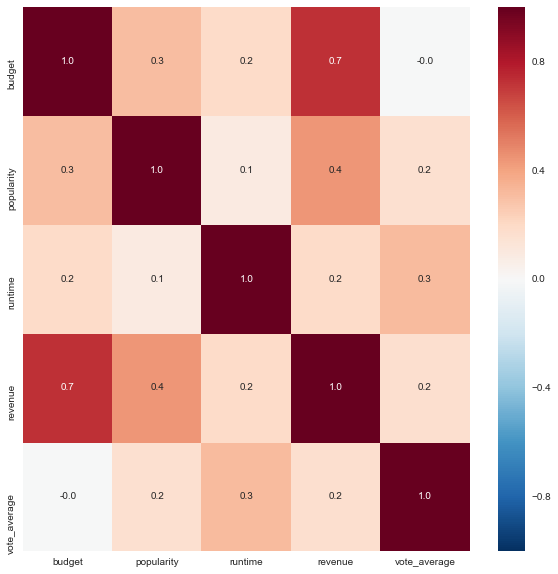

In [5]:
f,ax = plt.subplots(figsize = (10,10))
sns.heatmap(df.corr(),annot = True,fmt='.1f')

Com o gráfico acima obtemos os resultados das correlações entre cada coluna (variável). Como queremos achar uma forma de estimar o retorno financeiro de um filme ao final do projeto, precisamos analisar as variáveis em relação à variável 'Revenue'. Dessa forma percebemos que, em nossa regressão, quanto maior a correlação de uma variável X em relação à nossa variável fixada (revenue), quanto mais próxima a 1, seja positiva ou negativamente, mais importante será na nossa regressão tal variável.

Logo, das variáveis escolhidas até o momento, podemos dizer que em ordem de maior relevância no cálculo da nossa regressão estão em ordem decrescente, primeiro Budget (ou custo de produção do filme), o qual era esperado ter grande impacto no retorno do mesmo. Logo em seguida vem Popularity ou a popularidade do filme (quanto falam dele). Depois, juntos, seguem as variáveis Runtime (Tempo corrido em tela do filme) e Vote Average (Nota do filme dada pela comunidade).

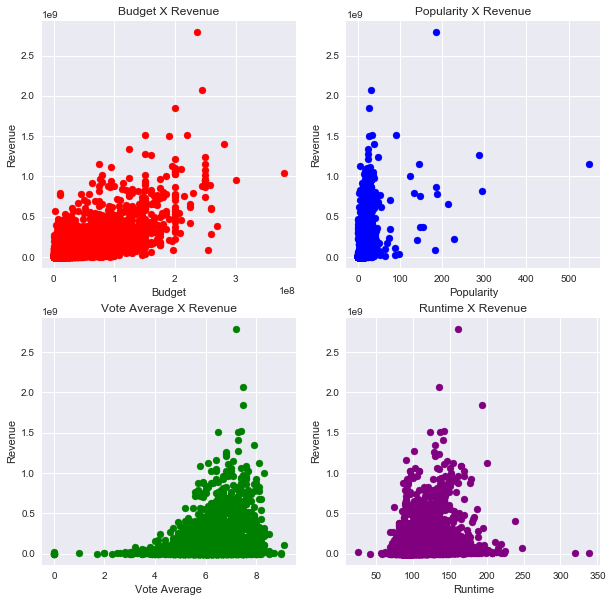

In [6]:
# Alguns ScatterPlot para analisar a dispersão dos dados em relação a revenue
fig=plt.figure(figsize=(10, 10))

# Budget X Revenue
plt.subplot(221)
plt.scatter(df.budget,df.revenue, color='red')
plt.title('Budget X Revenue')
plt.ylabel('Revenue')
plt.xlabel('Budget')

# Popularity X Revenue
plt.subplot(222)
plt.scatter(df.popularity,df.revenue, color='blue')
plt.title('Popularity X Revenue')
plt.ylabel('Revenue')
plt.xlabel('Popularity')

# Vote Average X Revenue
plt.subplot(223)
plt.scatter(df.vote_average,df.revenue, color='green')
plt.title('Vote Average X Revenue')
plt.ylabel('Revenue')
plt.xlabel('Vote Average')

#Runtime X Revenue
plt.subplot(224)
plt.scatter(df.runtime,df.revenue, color='purple')
plt.title('Runtime X Revenue')
plt.ylabel('Revenue')
plt.xlabel('Runtime')

plt.show()

Nos gráficos de dispersão acima podemos verificar o quão dispersos são os dados e visualiza-los em relação ao retorno financeiro (revenue). Percebemos que, como já visto em suas respectivas correlações, todos são positivos, logo quando o retorno é maior, a váriavel em questão (seja budget, popularidade ou tempo corrido) também é maior. A diferença desse gráfico para a tabela de correlações é que como já diz o nome deste, podemos verificar a disperção das variáveis.

A parte curiosa disso é que alguns filmes conseguem um retorno alto, mesmo tendo uma produção barata seja por motivos quaisquer, como é o caso de alguns filmes de terror que por não usar muito dinheiro, sua credibilidade aumenta, aumentando no caso também o fator "Terror" e assim chegando a cada vez mais cinemas e conseguindo um retorno de um filme blockbuster produzido por alguma empresa grande. Além disso, os gráficos nos mostram que um filme popular entre as pessoas, não necessariamente vai trazer um retorno alto.

Também temos dois gráficos que parecem um pouco com uma distribuição normal, possuindo uma média de tempo corrido de tela e classificação (ou nota) do público para o filme para um retorno maior do longa.

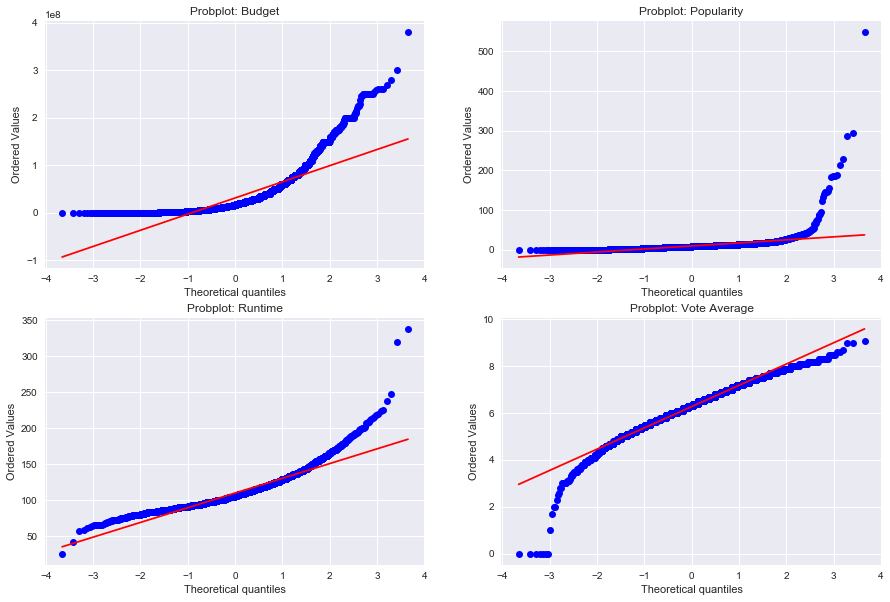

In [7]:
# Gráficos que verificam se alguma das variáveis analisadas tende a uma distribuição normal
fig=plt.figure(figsize=(15, 10))

plt.subplot(221)
stats.probplot(df.budget, plot=plt)
plt.title('Probplot: Budget')

plt.subplot(222)
stats.probplot(df.popularity, plot=plt)
plt.title('Probplot: Popularity')

plt.subplot(223)
stats.probplot(df.runtime, plot=plt)
plt.title('Probplot: Runtime')

plt.subplot(224)
stats.probplot(df.vote_average, plot=plt)
plt.title('Probplot: Vote Average')
plt.show()

Os Probability Plots acima (gráficos que medem o quanto uma base e dados se distribui conforme uma distribuição Gaussiana ou Normal), nos mostram que nenhum das variáveis se comporta como uma. A hipótese que tínhamos anteriormente nos gráficos de dispersão, de que as variáveis "Runtime" (tempo corrido de tela) e "Vote Average" (nota do filme pelo público) seguem tal distribuição não se confirmam. Pelo incrível que pareça, a variável que mais tende a tal é a de popularidade do filme com o público, independendo de sua nota dada pelo mesmo. Porém não se pode dizer que nenhuma das variáveis se distribui de forma gaussiana, anulando essas hipóteses.

Agora podemos seguir adiante da Análise exploratória dos dados.

___
## Iniciando a Regressão Linear Múltipla Quantitativa

In [8]:
X=df[['budget', 'popularity', 'runtime', 'vote_average']]
xc=sm.add_constant(X)
model=sm.OLS(df.revenue,xc)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     2035.
Date:                Thu, 22 Nov 2018   Prob (F-statistic):               0.00
Time:                        22:38:27   Log-Likelihood:            -1.0677e+05
No. Observations:                5369   AIC:                         2.135e+05
Df Residuals:                    5364   BIC:                         2.136e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.761e+08   1.08e+07    -16.266      0.000   -1.97e+08   -1.55e+08
budget           2.7534      0.038     71.942      0.000       2.678       2.828
popularity    2.566e+06    1.1e+05     23.235      0.000    2.35e+06    2.78e+06
runtime       2225.7085   7.17e+04      0.031      0.975   -1.38e+05    1.43e+05
vote_average  2.478e+07   1.66e+06     14.915      0.000    2.15e+07     2.8e+07
==============================================================================
Omnibus:                     4175.948   Durbin-Watson:                   1.765
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           229343.981
Skew:                           3.245   Prob(JB):                         0.00
Kurtosis:                      34.354   Cond. No.                     3.87e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.87e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Com o primeiro teste de regressão linear múltipla feita na célula acima (utilizando a biblioteca Statsmodels), conseguimos ter uma visão inicial do caminho que devemos seguir a partir de agora. Vamos analisar!

Primeiro vamos olhar para o nosso **`R`²** que possui o valor de **0.603**. Dado esse valor, sabemos que a regressão ainda tem muito a ser melhorada (quanto mais próximo de **1** o **`R²`**, mais preciso está o modelo), devemos olhar para mais variáveis que possam explicar nosso modelo. No caso utilizamos por enquanto apenas as variáveis quantitativas, mas ainda temos algumas Qualitativas para implementar em nosso modelo.

A segunda coisa que devemos dar nossa atenção são as **`P-values`**, sendo que todas as variáveis, exceto uma, possuem um **`p-value`** de **0**, porém temos _runtime_ que possui **0.975**. O problema de um valor alto nesse caso é porque isso prova que a variável em questão está mais atrapalhando do que ajudando a precisão da nossa regressão.

As últimas coisas que devemos dar enfoque na primeira análise do modelo são a **`Prob(F-statistic)`**, a **`Prob(Omnibus)`** e a **`Prob(Jarque-Bera)`**. No caso a **`F-statistic`** coloca sob a hipótese nula de que todos os $\beta$ 's (a não ser o $\beta_0$) são iguais a zero e verifica o quão próximo tal modelo estaria do então calculado. Dado que a probabildade é **0**, logo podemos afirmar que o modelo precisa de tais variáveis.

Já a **`Prob(Omnibus)`** testa se os resíduos do nosso modelo tendem a uma normal. É importante que os resíduos tendam a uma distribuição gaussiana, pois se os resíduos não se distribuírem como uma normal, então a hipótese de que eles se comportam como uma amostra aleatória de uma população maior será dada como uma mentira e isso comprometerá totalmente a veracidade da regressão. No caso temos **$Prob(Omnibus) = 0.00$**, sendo assim não podemos confiar neste modelo. 

Ainda temos a **`Prob(JB)`** que realiza o teste chamado **`Jarque-Bera`**, que utiliza as mesmas hipóteses que o teste **`Omnibus`**, porém utilizando um método diferente, fazendo uso do grau de assimetria da distribuição (Skew) e do grau de achatamento da mesma (Kurtosis). Um **`Skew`** mais próximo de **0** e um **`Kurtosis`** mais próximo de **3** são os mais precisos para uma distribuição gaussiana dos resíduos, porém ainda temos resíduos _"reprovados"_ em ambos os testes.

In [9]:
dfQuant=df.copy()
dfQuant=dfQuant[['budget', 'popularity','vote_average']]

___
# Trabalhando com as variáveis qualitativas:
 **1. Filtrando Gêneros de filmes**

Nesta etapa decidimos também analisar uma regressão das variáveis qualitativas com o retorno do filme separadamente, para entender melhor o que cada uma representa

In [10]:
# Função que retorna uma lista com os diferentes tipos de classificações. Ex: Diferentes tipos de generos de filmes
def coluna(df): # O argumento é uma coluna do dataframe com listas para cada filme
    lista=[] # lista que vamos retornar no final
    for i in df: # percorre o dataframe, filme por filme
        for j in i: # percorre a lista de cada filme
            if j not in lista:
                lista.append(j) # adiciona categorias únicas sem repetição à lista
            else:
                pass
    return lista

In [11]:
# Função que transforma o dicionário que vem em genres e cria uma lista com listas de generos para cada filme
def func_genero(filme): # Recebe uma string que contém dicionarios
    l=eval(filme)
    retl = []
    c=0
    for i in l:
        genero=i['name']
        c+=1
        retl.append(genero)
    return retl

In [12]:
dfGen = df.copy()

In [13]:
# Arrumando a coluna de genêros para ser utilizada na regressão
dfGen['GENERO']=dfGen.genres.apply(func_genero)

In [14]:
for nome in coluna(dfGen.GENERO):
    dfGen[nome]=0

In [15]:
for k in dfGen.index:
    gens = dfGen.loc[k,:].GENERO   
    for g in gens:
        dfGen.loc[k,g]=1

In [16]:
dfGen=dfGen[['Crime','Comedy','Adventure','Action','Science Fiction','Animation','Family','Drama','Romance','Mystery',
       'Music','Fantasy','Thriller','War','Western','History','Horror','Documentary','Foreign','TV Movie']]

In [17]:
# Impacto dos generos no revenue
X=dfGen
xc=sm.add_constant(X)
model=sm.OLS(df.revenue,xc)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     53.18
Date:                Thu, 22 Nov 2018   Prob (F-statistic):          4.31e-193
Time:                        22:38:46   Log-Likelihood:            -1.0876e+05
No. Observations:                5369   AIC:                         2.176e+05
Df Residuals:                    5348   BIC:                         2.177e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            9.008e+07   6.13e+06     14.687      0.000    7.81e+07    1.02e+08
Crime           -8.196e+06   6.33e+06     -1.295      0.195   -2.06e+07    4.21e+06
Comedy           -2.41e+07   5.24e+06     -4.596      0.000   -3.44e+07   -1.38e+07
Adventure        8.019e+07   6.35e+06     12.624      0.000    6.77e+07    9.26e+07
Action           3.115e+07   5.68e+06      5.484      0.000       2e+07    4.23e+07
Science Fiction  2.215e+07   6.97e+06      3.178      0.001    8.49e+06    3.58e+07
Animation        5.627e+07   1.13e+07      4.968      0.000    3.41e+07    7.85e+07
Family            3.83e+07   9.08e+06      4.216      0.000    2.05e+07    5.61e+07
Drama           -3.637e+07   5.08e+06     -7.165      0.000   -4.63e+07   -2.64e+07
Romance          5.493e+05    5.8e+06      0.095      0.925   -1.08e+07    1.19e+07
Mystery          6.826e+06   8.02e+06      0.852      0.395   -8.89e+06    2.25e+07
Music           -1.099e+07   1.14e+07     -0.961      0.337   -3.34e+07    1.14e+07
Fantasy          5.795e+07   7.61e+06      7.617      0.000     4.3e+07    7.29e+07
Thriller        -9.933e+06   5.65e+06     -1.759      0.079    -2.1e+07    1.14e+06
War             -8.053e+06   1.16e+07     -0.692      0.489   -3.09e+07    1.48e+07
Western         -5.354e+07   1.65e+07     -3.253      0.001   -8.58e+07   -2.13e+07
History         -1.271e+07    1.1e+07     -1.152      0.249   -3.43e+07    8.92e+06
Horror          -4.302e+07   7.58e+06     -5.673      0.000   -5.79e+07   -2.82e+07
Documentary     -6.399e+07   2.06e+07     -3.111      0.002   -1.04e+08   -2.37e+07
Foreign         -5.549e+07   2.71e+07     -2.051      0.040   -1.09e+08   -2.45e+06
TV Movie        -1.141e+08   1.52e+08     -0.748      0.454   -4.13e+08    1.85e+08
==============================================================================
Omnibus:                     4721.314   Durbin-Watson:                   1.701
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           252813.154
Skew:                           3.982   Prob(JB):                         0.00
Kurtosis:                      35.660   Cond. No.                         95.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Antes de passar para a próxima etapa, vamos entender os dados acima**

Analisando o modelo de regressão que só utiliza os gêneros de cada filme, percebemos que, no geral, o gênero de um filme não impacta tanto assim no retorno financeiro do filme. Porém mesmo assim sabemos que o **$R^2$** é **0.166** (o que também pode ser lido como: os gêneros podem explicar **16.6%** do retorno do filme), isso se deve por conta das preferências das pessoas por um gênero em específico. Uma forma de checar um gênero favorito seria olhar para os `p-values`, onde temos por exemplo o gênero `Animação` sendo mais preferível do que um filme do gênero `Romance`.

Também temos que a **`Prob(F-statistic)`** é um pouco maior do que das variáveis quantitativas, mas continua muito próxima de zero, o que significa que o modelo precisa de tais variáveis com excessão de algumas, porém não iremos removê-las, pois remover um gênero seria ignorar a existência dele no modelo. Além de tudo, os resíduos também se comportam como uma normal.

**2. Filtrando Países de produção**

In [18]:
dfPais=df.copy()

In [19]:
dfPais['PAISES']=dfPais.production_countries.apply(func_genero)

In [20]:
for nome in coluna(dfPais.PAISES):
    dfPais[nome]=0

In [21]:
for k in dfPais.index:
    pais = dfPais.loc[k,:].PAISES  
    for p in pais:
        dfPais.loc[k,p]=1

In [22]:
dfPais=dfPais[['United States of America','Argentina','Denmark','Finland','France','Germany','Iceland','Italy','Netherlands',
      'Norway','Sweden','United Kingdom','Mexico','Canada','Spain','Austria','Switzerland','Hong Kong','China','Japan',
      'Uruguay','Paraguay','Ireland','Luxembourg','Russia','Australia','New Zealand','Taiwan','South Africa','Czech Republic',
      'Hungary','Poland','India','Malta','Brazil','Portugal','Bahamas','South Korea','Belgium','Bulgaria','Costa Rica',
      'Morocco','Liechtenstein','Pakistan','Romania','Turkey','Algeria','Slovenia','Peru','Lithuania','Botswana','Israel',
      'Thailand','Tunisia','Serbia','Singapore','Kazakhstan','Namibia','Ukraine','Greece','Ecuador','Iran',
      'United Arab Emirates','Monaco','Angola','Cyprus','Philippines','Mali','Burkina Faso','Ghana','Qatar','Indonesia',
      'Serbia and Montenegro','Croatia','Chile','Puerto Rico','Cambodia','Colombia','Venezuela','Malaysia']]

In [23]:
X=dfPais
xc=sm.add_constant(X)
model=sm.OLS(df.revenue,xc)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     4.310
Date:                Thu, 22 Nov 2018   Prob (F-statistic):           4.63e-32
Time:                        22:38:57   Log-Likelihood:            -1.0909e+05
No. Observations:                5369   AIC:                         2.183e+05
Df Residuals:                    5291   BIC:                         2.188e+05
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     2.383e+07   7.51e+06      3.175      0.002    9.12e+06    3.85e+07
United States of America  7.711e+07   7.44e+06     10.367      0.000    6.25e+07    9.17e+07
Argentina                -2.441e+07      6e+07     -0.407      0.684   -1.42e+08    9.33e+07
Denmark                   -2.75e+07   4.19e+07     -0.657      0.511    -1.1e+08    5.46e+07
Finland                  -1.602e+07   4.43e+07     -0.362      0.717   -1.03e+08    7.07e+07
France                     -1.7e+07   9.84e+06     -1.728      0.084   -3.63e+07    2.29e+06
Germany                     3.4e+06   9.88e+06      0.344      0.731    -1.6e+07    2.28e+07
Iceland                   2.163e+07    7.6e+07      0.285      0.776   -1.27e+08    1.71e+08
Italy                    -8.951e+06   1.69e+07     -0.530      0.596    -4.2e+07    2.41e+07
Netherlands              -1.551e+07   3.22e+07     -0.482      0.630   -7.85e+07    4.75e+07
Norway                   -1.864e+07   4.47e+07     -0.417      0.677   -1.06e+08     6.9e+07
Sweden                    4.208e+06   3.63e+07      0.116      0.908    -6.7e+07    7.54e+07
United Kingdom            3.793e+07   7.18e+06      5.281      0.000    2.39e+07     5.2e+07
Mexico                   -3.209e+07   3.16e+07     -1.016      0.310    -9.4e+07    2.99e+07
Canada                   -1.185e+07    1.1e+07     -1.081      0.280   -3.33e+07    9.64e+06
Spain                    -3.641e+06   2.07e+07     -0.176      0.860   -4.41e+07    3.69e+07
Austria                  -1.549e+07    4.6e+07     -0.337      0.736   -1.06e+08    7.48e+07
Switzerland              -4.533e+07   4.11e+07     -1.104      0.270   -1.26e+08    3.51e+07
Hong Kong                -3.702e+07   2.51e+07     -1.474      0.141   -8.63e+07    1.22e+07
China                      9.13e+07   2.13e+07      4.280      0.000    4.95e+07    1.33e+08
Japan                     8.393e+06   1.76e+07      0.476      0.634   -2.62e+07     4.3e+07
Uruguay                   2.972e+07   8.14e+07      0.365      0.715    -1.3e+08    1.89e+08
Paraguay                  2.972e+07   8.14e+07      0.365      0.715    -1.3e+08    1.89e+08
Ireland                  -3.816e+07   2.48e+07     -1.540      0.124   -8.67e+07    1.04e+07
Luxembourg               -5.075e+07   4.77e+07     -1.063      0.288   -1.44e+08    4.28e+07
Russia                   -1.748e+07   1.98e+07     -0.882      0.378   -5.64e+07    2.14e+07
Australia                 9.476e+06   1.52e+07      0.624      0.533   -2.03e+07    3.92e+07
New Zealand               2.129e+08   3.01e+07      7.066      0.000    1.54e+08    2.72e+08
Taiwan                    7.913e+07   5.94e+07      1.331      0.183   -3.74e+07    1.96e+08
South Africa             -3.559e+07   3.97e+07     -0.896      0.370   -1.13e+08    4.23e+07
Czech Republic

**Explicação dos dados acima**

O modelo de regressão apenas com os países que produziram os filmes não agrega tanto assim para o nosso modelo. Como é de se pensar, os países mais envolvidos são aqueles com as `p-values` mais próximas ou iguais a zero, logo temos por exemplo: Estados Unidos, Reino Unido, Nova Zelandia, Malta, etc. Esses países são os mais participativos na indústria cinematográfica e sendo assim, um filme produzido por eles agrega ao valor final de retorno financeiro, mas o impacto na regressão é tão pequeno que seu **$R^2$** é de **0.059** ou, podemos dizer que os países envolvidos na produção de um filme (em muitos casos são mais de um país), explicam **5.9%** do retorno daquele mesmo filme.

A partir de agora, filtramos o dataframe de países, por conta de boa parte deles possuírem **`P-values`** muito maiores do que um nível de significância de **5%**. Com isso inserimos o código abaixo que elimina colunas de países que são desinteressantes para o nosso modelo, incrementando-o.

In [24]:
# Código para limpar dataframe de países e utilizar os com p-value menores que 0.05 (nível de significância)
for i in list(dfPais):
    if results.pvalues[i]>0.05:
        dfPais=dfPais.drop(columns=[i])
    else:
        pass

**Observação:**

Percebemos que o _Adjusted **$R^2$**_ deve tender ao nosso **$R^2$**, sendo assim uma diferença grande entre eles revela uma necessidade de retirar colunas com **`p-values`** muito altos 

**3. Filtrando Empresas que produziram cada filme**

In [25]:
dfComp=df.copy()

In [26]:
dfComp['EMPRESAS']=dfComp.production_companies.apply(func_genero)

In [27]:
for nome in coluna(dfComp.EMPRESAS):
    dfComp[nome]=0

In [28]:
for k in dfComp.index:
    comp = dfComp.loc[k,:].EMPRESAS  
    for c in comp:
        dfComp.loc[k,c]=1

In [29]:
dfComp=dfComp.drop(columns=['production_companies','popularity','revenue','original_title','genres','original_language','budget',
                   'release_date','production_countries','vote_average','runtime','EMPRESAS'])

In [ ]:
X=dfComp
xc=sm.add_constant(X)
model=sm.OLS(df.revenue,xc)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     1.785
Date:                Thu, 22 Nov 2018   Prob (F-statistic):           3.51e-44
Time:                        22:42:58   Log-Likelihood:            -1.0537e+05
No. Observations:                5369   AIC:                         2.177e+05
Df Residuals:                    1909   BIC:                         2.405e+05
Df Model:                        3459                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================================================
                                                                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                   1.673e+07   7.24e+06      2.310      0.021    2.53e+06    3.09e+07
Miramax Films                                                                          -8.237e+06   2.55e+07     -0.323      0.747   -5.82e+07    4.17e+07
A Band Apart                                                                            7.025e+07   8.89e+07      0.790      0.430   -1.04e+08    2.45e+08
Lucasfilm                                                                               4.171e+08   3.69e+07     11.304      0.000    3.45e+08    4.89e+08
Twentieth Century Fox Film Corporation                                                  4.965e+07   1.55e+07      3.195      0.001    1.92e+07    8.01e+07
Pixar Animation Studios                                                                  4.89e+08    3.7e+07     13.204      0.000    4.16e+08    5.62e+08
Paramount Pictures                                                                      6.132e+07    1.3e+07      4.720      0.000    3.58e+07    8.68e+07
DreamWorks SKG                                                                          2.507e+07   2.69e+07      0.933      0.351   -2.76e+07    7.78e+07
Jinks/Cohen Company                                                                     2.717e+08   1.09e+08      2.488      0.013    5.75e+07    4.86e+08
RKO Radio Pictures                                                                      2.441e+07   3.57e+07      0.683      0.494   -4.56e+07    9.44e+07
Mercury Productions                                                                    -1.792e+07    1.4e+08     -0.128      0.898   -2.93e+08    2.57e+08
Fine Line Features                                                                     -1.309e+07    6.1e+07     -0.215      0.830   -1.33e+08    1.07e+08
Zentropa Entertainments                                                                -1.434e+06   6.46e+07     -0.022      0.982   -1.28e+08    1.25e+08
Danmarks Radio (DR)                                                                    -1.763e+07   5.71e+07     -0.309      0.758    -1.3e+08    9.44e+07
SVT Drama                                                                              -3.235e+07   2.53e+07     -1.276      0.202   -8.21e+07    1.74e+07
Arte                                                                                    7.446e+07   7.12e+07      1.045      0.296   -6.52e+07    2.14e+08
Memfis Film                                                                            -5.306e+07    4.3e+07     -1.233      0.218   -1.37

**Análise regressão de empresas produtoras**

A partir do modelo de regressão com empresas produtoras percebemos que essa seria uma das variáveis mais influentes no modelo (acima de Budget inclusive!). Porém nem tudo são flores, o **$R^2$** apesar de ser muito bom **(0.764)**, nosso _adjuted $R^2$_ possui o valor de **0.336**, deixando uma diferença razoável entre os dois e por isso surge a necessidade de remover colunas com **`p-values`** maiores que **0.05** (nível de significância adotado).

In [ ]:
for i in list(dfComp):
    if results.pvalues[i]>0.05:
        dfComp=dfComp.drop(columns=[i])
    else:
        pass

**4. Filtrando Idioma**

In [ ]:
dfIdioma=df.loc[:,'original_language']

In [ ]:
dfIdioma=pd.get_dummies(dfIdioma)

In [ ]:
X=dfIdioma
xc=sm.add_constant(X)
model=sm.OLS(df.revenue,xc)
results=model.fit()
results.summary()

**Análise da regressão de idiomas**

Percebemos que o idioma falado do filme não impactam tanto no modelo. Mesmo assim é interessante manter a variável, pois agregará na próxima etapa da regressão. Ainda assim optamos por remover **`p-values`** maiores que **0.05**, para deixar a regressão final ainda mais precisa.

In [ ]:
for i in list(dfIdioma):
    if results.pvalues[i]>0.05:
        dfIdioma=dfIdioma.drop(columns=[i])
    else:
        pass

In [ ]:
dfIdioma=dfIdioma.add_suffix('_')

___
# Regressão Linear Múltipla - Completa

Nesta etapa iremos juntar as variáveis obtidas até então e conseguir a nossa regressão linear múltipla final. Lembrando que limpamos algumas colunas das variáveis: _Idioma_, _País de produção_ e _Empresas Produtoras_ por conta de **`p-values`** maiores que **0.05**, assim diminuindo a diferença entre o **$R^2$** e o _adjusted $R^2$_ e evidenciando uma melhor precisão do modelo. Também é importante evidenciar de que achamos melhor continuar com os gêneros sem limpá-los como fizemos com outras variáveis, pois remover um gênero seria ignorar a existência dele na população geral.

In [ ]:
dfTotal=dfComp
nomes_idioma=list(dfIdioma)
nomes_gen=list(dfGen)
nomes_quant=list(dfQuant)
nomes_pais=list(dfPais)
for coluna in nomes_idioma:
    dfTotal[coluna]=dfIdioma[coluna]
for coluna in nomes_gen:
    dfTotal[coluna]=dfGen[coluna]
for coluna in nomes_quant:
    dfTotal[coluna]=dfQuant[coluna]
for coluna in nomes_pais:
    dfTotal[coluna]=dfPais[coluna]

In [ ]:
X=dfTotal
xc=sm.add_constant(X)
model=sm.OLS(df.revenue,xc)
results=model.fit()
results.summary()

O modelo final se mostra preciso, dado o **$R^2$** de **0.747**. Temos também uma diferença que chega a ser mínima entre os valores do **$R^2$** e _**adj. $R^2$**_.

Fazendo uma análise mais completa, vamos olhar para o **Prob(F-statistic)** que se iguala a zero, portanto essa é a probabilidade do modelo continuar igual sob a hipótese nula de que os coeficientes são iguais a zero e, por esse valor ser zero, essa hipótese é negada, logo todos as variáveis são necessárias para o modelo funcionar de fato.

Também vamos analisar o **Prob(Omnibus)** e **Prob(JB)**, que medem se os resíduos da regressão se comportam como uma distribuição Gaussiana ou Normal por métodos diferentes. A probabilidade ser zero indica que os resíduos se comportam como uma e, logo, os dados de fato são de uma amostra aleatória de uma população maior.

___
## Conclusão

Concluindo, devemos relembrar a pergunta feita no início do projeto: Quais variáveis são necessárias para se explicar o retorno financeiro de um filme? E quais são as mais importantes?

No caso, para se obter um **$R^2$** de **0.747** para um modelo de regressão linear múltipla com a variável dependente sendo o retorno do filme, precisamos das seguintes variáveis: 

**Quantitativas:**

-Budget (Dinheiro gasto com a produção do filme)

-Popularidade do longa entre o público (e isso varia conforme seu marketing e divulgação)

-Nota do filme dada pela comunidade (Varia conforme aceitação do filme pelo público)

**Qualitativas:**

-Empresas envolvidas na produção do filme

-Países de Produção

-Idioma falado no filme

-Gênero do filme

Por mais que algumas dessas variáveis interfirem pouco na estimação do retorno do filme, elas que foram utilizadas por nós para obter tal **$R^2$**. Mesmo assim sabemos que se pode obter um valor maior é preciso de outras variáveis e ainda existe muito a ser explicado. Poderíamos ainda ter colocado avaliações do IMDB (site de avaliação de filmes), Atores presentes no filme, países de produção, se são continuações de sagas ou trilogias, entre outras variáveis, porém por limitação de tempo principalmente, não conseguimos implementá-las em nosso modelo.

Para descobrir o impacto de cada variável no cálculo, devemos olhar para os sumários de regressão feitos com as variáveis sozinhas ao longo do código. Vamos ohar para os valores de **$R^2$** mais uma vez, pois este valor equivale ao quanto determinada variável explica o modelo. Com isso temos a seguinte _ordem de importância de variáveis_:

-Empresas presentes na produção. ($R^2 = 0.764$)

-Budget ($R^2 = 0.533$)

-Popularidade do longa entre o público ($R^2 = 0.194$)

-Gênero do filme ($R^2 = 0.166$)

-Países envolvidos na produção ($R^2 = 0.059$)

-Nota do filme dada pela comunidade ($R^2 = 0.028$)

-Idioma falado no filme ($R^2 = 0.019$)

Como é esperado, o budget e as empresas presentes na produção de um filme impactam bastante no valor de retorno financeiro de um filme, logo o nome da empresa é muito associado ao futuro retorno do filme sendo produzido. 

Pensando na Indústria Cinematográfica, nosso modelo está muito próximo da realidade, temos o exemplo:

Um filme de uma empresa grande como a Lucasfilms decide retornar com sua franquia Star Wars com um derivado, dos gêneros de Comédia e Ação, com uma extensa divulgação e um investimento grandíssimo, terá um grande retorno financeiro, baseado em nossos $\beta$ 's (todos positivos) terá um retorno financeiro altíssimo.

___
### Sobre o Grupo:

Nós 3 trabalhamos juntos no projeto e da mesma forma, porém cada um teve maior participação em partes específicas.
O Lucas e o Matheus abriram o projeto analisando o dataframe e selecionando as variáveis. O Matheus fez ainda um código que acabou não sendo utilizado para adicionar a coluna IMDB, porém o dataframe possuía poucos dados. O Rafael fez os textos e produziu junto ao Lucas as funções feitas a mão. Ainda assim, os três trabalharam bastante juntos no mesmo computador presentes fisicamente no mesmo espaço, então podemos dizer que o projeto foi elaborado em conjunto por nós 3.